In [1]:
# A Hybrid Classical-Quantum Approach to Equity Market Direction Classification
# Complete Implementation - Error-Free Version

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib backend to avoid display issues
plt.style.use('default')

def safe_import_quantum():
    """Safely import quantum libraries with fallback"""
    try:
        from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
        from qiskit_algorithms.optimizers import COBYLA
        try:
            from qiskit.primitives import StatevectorSampler as Sampler
        except ImportError:
            from qiskit.primitives import Sampler
        from qiskit_machine_learning.algorithms.classifiers import VQC
        return True, (ZZFeatureMap, RealAmplitudes, COBYLA, Sampler, VQC)
    except ImportError:
        return False, None

def safe_import_stats():
    """Safely import statsmodels with fallback"""
    try:
        from statsmodels.tsa.stattools import adfuller
        return True, adfuller
    except ImportError:
        print("statsmodels not available - skipping stationarity tests")
        return False, None

def safe_import_sklearn():
    """Safely import sklearn with fallback"""
    try:
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
        from sklearn.preprocessing import MinMaxScaler
        return True, (RandomForestClassifier, accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, MinMaxScaler)
    except ImportError:
        print("sklearn not available - classical ML will be skipped")
        return False, None

# Import libraries safely
QUANTUM_AVAILABLE, quantum_libs = safe_import_quantum()
STATS_AVAILABLE, adfuller = safe_import_stats()
SKLEARN_AVAILABLE, sklearn_libs = safe_import_sklearn()

if SKLEARN_AVAILABLE:
    RandomForestClassifier, accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, MinMaxScaler = sklearn_libs

print("Hybrid Classical-Quantum Stock Market Direction Classification")
print("=" * 80)
print(f"Libraries Available:")
print(f"  - Quantum: {'✓' if QUANTUM_AVAILABLE else '✗'}")
print(f"  - Statistics: {'✓' if STATS_AVAILABLE else '✗'}")
print(f"  - Scikit-learn: {'✓' if SKLEARN_AVAILABLE else '✗'}")

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def safe_series_operation(data, operation_name="operation"):
    """Safely convert data to pandas Series"""
    try:
        if isinstance(data, pd.Series):
            return data, True
        elif isinstance(data, pd.DataFrame):
            if data.shape[1] == 1:
                return data.iloc[:, 0], True
            else:
                print(f"Warning: {operation_name} - DataFrame has multiple columns, using first column")
                return data.iloc[:, 0], True
        elif isinstance(data, np.ndarray):
            if data.ndim == 1:
                return pd.Series(data), True
            elif data.ndim == 2 and data.shape[1] == 1:
                return pd.Series(data.flatten()), True
            else:
                print(f"Warning: {operation_name} - Array has wrong shape, using flattened version")
                return pd.Series(data.flatten()), True
        else:
            return pd.Series(data), True
    except Exception as e:
        print(f"Error in {operation_name}: {e}")
        return pd.Series(), False

def safe_calculate_sma(data, window, name="SMA"):
    """Safely calculate Simple Moving Average"""
    try:
        series, success = safe_series_operation(data, f"{name}_{window}")
        if success and len(series) > window:
            result = series.rolling(window=window, min_periods=1).mean()
            print(f"  ✓ {name}_{window} calculated successfully")
            return result, True
        else:
            print(f"  ✗ {name}_{window} failed - insufficient data")
            return pd.Series(index=data.index if hasattr(data, 'index') else range(len(data))), False
    except Exception as e:
        print(f"  ✗ {name}_{window} failed: {e}")
        return pd.Series(index=data.index if hasattr(data, 'index') else range(len(data))), False

def safe_calculate_rsi(data, window=14):
    """Safely calculate Relative Strength Index"""
    try:
        series, success = safe_series_operation(data, "RSI")
        if not success or len(series) < window * 2:
            print(f"  ✗ RSI failed - insufficient data")
            return pd.Series(index=data.index if hasattr(data, 'index') else range(len(data))), False
        
        delta = series.diff()
        gain = delta.where(delta > 0, 0).rolling(window=window, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
        
        # Avoid division by zero
        loss_safe = loss.replace(0, 0.000001)
        rs = gain / loss_safe
        rsi = 100 - (100 / (1 + rs))
        
        # Handle any remaining NaN or inf values
        rsi = rsi.fillna(50).replace([np.inf, -np.inf], 50)
        
        print(f"  ✓ RSI calculated successfully")
        return rsi, True
        
    except Exception as e:
        print(f"  ✗ RSI failed: {e}")
        return pd.Series(index=data.index if hasattr(data, 'index') else range(len(data))), False

def safe_calculate_macd(data, fast=12, slow=26, signal=9):
    """Safely calculate MACD"""
    try:
        series, success = safe_series_operation(data, "MACD")
        if not success or len(series) < slow * 2:
            print(f"  ✗ MACD failed - insufficient data")
            empty_series = pd.Series(index=data.index if hasattr(data, 'index') else range(len(data)))
            return empty_series, empty_series, empty_series, False
        
        exp1 = series.ewm(span=fast, adjust=False).mean()
        exp2 = series.ewm(span=slow, adjust=False).mean()
        macd_line = exp1 - exp2
        signal_line = macd_line.ewm(span=signal, adjust=False).mean()
        histogram = macd_line - signal_line
        
        # Handle NaN values
        macd_line = macd_line.fillna(0)
        signal_line = signal_line.fillna(0)
        histogram = histogram.fillna(0)
        
        print(f"  ✓ MACD calculated successfully")
        return macd_line, signal_line, histogram, True
        
    except Exception as e:
        print(f"  ✗ MACD failed: {e}")
        empty_series = pd.Series(index=data.index if hasattr(data, 'index') else range(len(data)))
        return empty_series, empty_series, empty_series, False

def safe_calculate_adx(high, low, close, window=14):
    """Safely calculate Average Directional Index"""
    try:
        high_series, high_ok = safe_series_operation(high, "ADX_high")
        low_series, low_ok = safe_series_operation(low, "ADX_low")
        close_series, close_ok = safe_series_operation(close, "ADX_close")
        
        if not (high_ok and low_ok and close_ok) or len(close_series) < window * 3:
            print(f"  ✗ ADX failed - insufficient or invalid data")
            empty_series = pd.Series(index=close.index if hasattr(close, 'index') else range(len(close)))
            return empty_series, empty_series, empty_series, False
        
        # Calculate True Range components
        tr1 = high_series - low_series
        tr2 = abs(high_series - close_series.shift(1))
        tr3 = abs(low_series - close_series.shift(1))
        
        # True Range
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1, skipna=True)
        
        # Directional movements
        high_diff = high_series.diff()
        low_diff = low_series.shift(1) - low_series
        
        dm_plus = pd.Series(np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0), index=high_series.index)
        dm_minus = pd.Series(np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0), index=low_series.index)
        
        # Smoothed averages
        atr = tr.rolling(window=window, min_periods=1).mean()
        atr_safe = atr.replace(0, 0.000001)
        
        di_plus = 100 * (dm_plus.rolling(window=window, min_periods=1).mean() / atr_safe)
        di_minus = 100 * (dm_minus.rolling(window=window, min_periods=1).mean() / atr_safe)
        
        # ADX calculation
        di_sum = di_plus + di_minus
        di_sum_safe = di_sum.replace(0, 0.000001)
        dx = 100 * abs(di_plus - di_minus) / di_sum_safe
        adx = dx.rolling(window=window, min_periods=1).mean()
        
        # Handle NaN and inf values
        adx = adx.fillna(25).replace([np.inf, -np.inf], 25)
        di_plus = di_plus.fillna(25).replace([np.inf, -np.inf], 25)
        di_minus = di_minus.fillna(25).replace([np.inf, -np.inf], 25)
        
        print(f"  ✓ ADX calculated successfully")
        return adx, di_plus, di_minus, True
        
    except Exception as e:
        print(f"  ✗ ADX failed: {e}")
        empty_series = pd.Series(index=close.index if hasattr(close, 'index') else range(len(close)))
        return empty_series, empty_series, empty_series, False

def safe_calculate_obv(close, volume):
    """Safely calculate On-Balance Volume"""
    try:
        close_series, close_ok = safe_series_operation(close, "OBV_close")
        volume_series, volume_ok = safe_series_operation(volume, "OBV_volume")
        
        if not (close_ok and volume_ok) or len(close_series) < 2:
            print(f"  ✗ OBV failed - insufficient or invalid data")
            return pd.Series(index=close.index if hasattr(close, 'index') else range(len(close))), False
        
        # Calculate price changes
        price_change = close_series.diff()
        
        # Calculate OBV changes
        obv_change = pd.Series(np.where(price_change > 0, volume_series,
                                      np.where(price_change < 0, -volume_series, 0)),
                              index=close_series.index)
        
        # Calculate cumulative OBV
        obv = obv_change.cumsum()
        obv = obv.fillna(0)
        
        print(f"  ✓ OBV calculated successfully")
        return obv, True
        
    except Exception as e:
        print(f"  ✗ OBV failed: {e}")
        return pd.Series(index=close.index if hasattr(close, 'index') else range(len(close))), False

def safe_plot(plot_func, title="Plot", figsize=(10, 6)):
    """Safely create plots with error handling"""
    try:
        plt.figure(figsize=figsize)
        plot_func()
        plt.title(title)
        plt.tight_layout()
        plt.show()
        return True
    except Exception as e:
        print(f"Warning: Could not create {title}: {e}")
        return False








Hybrid Classical-Quantum Stock Market Direction Classification
Libraries Available:
  - Quantum: ✓
  - Statistics: ✓
  - Scikit-learn: ✓


In [2]:
# ============================================================================
# PART I: DATA FOUNDATION AND PREPROCESSING
# ============================================================================

print("\nPART I: DATA ACQUISITION AND PREPROCESSING")
print("-" * 50)

try:
    # Data Acquisition
    print("1. Acquiring FTSE market data...")
    ticker = '^FTSE'
    start_date = '2010-01-01'
    
    data = yf.download(ticker, start=start_date, auto_adjust=False, progress=False)
    print("\n* Saving data to a local CSV file for future use...")
    try:
        data.to_csv('dataset.csv')
        print("✓ Data successfully saved to 'dataset.csv'")
    except Exception as e:
        print(f"✗ Failed to save data: {e}")
    
    if data.empty:
        raise ValueError("No data downloaded - check internet connection and ticker symbol")
    
    print(f"Downloaded {len(data)} trading days of FTSE data")
    print(f"Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
    
    # Ensure we have the required columns
    required_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    missing_cols = [col for col in required_cols if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    print("✓ Data acquisition successful")
    
except Exception as e:
    print(f"✗ Data acquisition failed: {e}")
    print("Creating synthetic data for demonstration...")
    
    # Create synthetic data as fallback
    dates = pd.date_range(start='2010-01-01', end='2023-12-31', freq='D')
    dates = dates[dates.weekday < 5][:3000]  # Business days only
    
    np.random.seed(42)
    base_price = 100
    returns = np.random.normal(0.001, 0.02, len(dates))
    prices = [base_price]
    
    for ret in returns[1:]:
        prices.append(prices[-1] * (1 + ret))
    
    prices = np.array(prices)
    
    data = pd.DataFrame({
        'Open': prices * (1 + np.random.normal(0, 0.001, len(dates))),
        'High': prices * (1 + abs(np.random.normal(0, 0.005, len(dates)))),
        'Low': prices * (1 - abs(np.random.normal(0, 0.005, len(dates)))),
        'Close': prices,
        'Adj Close': prices,
        'Volume': np.random.randint(50000000, 200000000, len(dates))
    }, index=dates)
    
    print(f"✓ Created synthetic dataset with {len(data)} days")
    print("\n* Saving data to a local CSV file for future use...")
    try:
        data.to_csv('spy_data_2010_present.csv')
        print("✓ Data successfully saved to 'spy_data_2010_present.csv'")
    except Exception as e:
        print(f"✗ Failed to save data: {e}")

# Calculate log returns
try:
    print("\n2. Calculating log returns and testing stationarity...")
    data['log_return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data['log_return'] = data['log_return'].fillna(0)
    
    if STATS_AVAILABLE:
        # Test stationarity on price
        adj_close = data['Adj Close'].dropna()
        try:
            adf_result_price = adfuller(adj_close)
            print(f'ADF Test (Price): Statistic={adf_result_price[0]:.4f}, p-value={adf_result_price[1]:.4f}')
            print("Price series is " + ("stationary" if adf_result_price[1] <= 0.05 else "non-stationary"))
        except:
            print("ADF test on prices failed")
        
        # Test stationarity on returns
        log_returns = data['log_return'].dropna()
        try:
            adf_result_returns = adfuller(log_returns)
            print(f'ADF Test (Returns): Statistic={adf_result_returns[0]:.4f}, p-value={adf_result_returns[1]:.4f}')
            print("Returns series is " + ("stationary" if adf_result_returns[1] <= 0.05 else "non-stationary"))
        except:
            print("ADF test on returns failed")
    
    print("✓ Log returns calculated successfully")
    
except Exception as e:
    print(f"Warning: Log returns calculation had issues: {e}")
    data['log_return'] = 0


PART I: DATA ACQUISITION AND PREPROCESSING
--------------------------------------------------
1. Acquiring FTSE market data...

* Saving data to a local CSV file for future use...
✓ Data successfully saved to 'dataset.csv'
Downloaded 3951 trading days of FTSE data
Date range: 2010-01-04 to 2025-08-27
✓ Data acquisition successful

2. Calculating log returns and testing stationarity...
ADF Test (Price): Statistic=-1.4540, p-value=0.5561
Price series is non-stationary
ADF Test (Returns): Statistic=-14.2395, p-value=0.0000
Returns series is stationary
✓ Log returns calculated successfully


In [3]:
# ============================================================================
# PART II: TECHNICAL INDICATOR ENGINEERING
# ============================================================================

print("\nPART II: TECHNICAL INDICATOR CALCULATION")
print("-" * 50)

print("3. Calculating technical indicators...")

# Initialize results dictionary
indicators = {}

# Calculate Simple Moving Averages
sma_50, sma_50_success = safe_calculate_sma(data['Adj Close'], 50, "SMA")
sma_200, sma_200_success = safe_calculate_sma(data['Adj Close'], 200, "SMA")

if sma_50_success:
    indicators['sma_50'] = sma_50
if sma_200_success:
    indicators['sma_200'] = sma_200

# Calculate RSI
rsi, rsi_success = safe_calculate_rsi(data['Adj Close'])
if rsi_success:
    indicators['rsi'] = rsi

# Calculate MACD
macd, macd_signal, macd_hist, macd_success = safe_calculate_macd(data['Adj Close'])
if macd_success:
    indicators['macd'] = macd
    indicators['macd_signal'] = macd_signal
    indicators['macd_hist'] = macd_hist

# Calculate ADX
adx, adx_pos, adx_neg, adx_success = safe_calculate_adx(data['High'], data['Low'], data['Adj Close'])
if adx_success:
    indicators['adx'] = adx
    indicators['adx_pos'] = adx_pos
    indicators['adx_neg'] = adx_neg

# Calculate OBV
obv, obv_success = safe_calculate_obv(data['Adj Close'], data['Volume'])
if obv_success:
    indicators['obv'] = obv

# Add indicators to main dataframe
for name, indicator in indicators.items():
    try:
        if len(indicator) == len(data):
            data[name] = indicator
        else:
            print(f"Warning: {name} length mismatch, aligning to data index")
            data[name] = indicator.reindex(data.index, fill_value=0)
    except Exception as e:
        print(f"Warning: Could not add {name} to dataframe: {e}")

print(f"\n✓ Successfully calculated {len(indicators)} technical indicators")
print(f"Available indicators: {list(indicators.keys())}")


PART II: TECHNICAL INDICATOR CALCULATION
--------------------------------------------------
3. Calculating technical indicators...
  ✓ SMA_50 calculated successfully
  ✓ SMA_200 calculated successfully
  ✓ RSI calculated successfully
  ✓ MACD calculated successfully
  ✓ ADX calculated successfully
  ✓ OBV calculated successfully

✓ Successfully calculated 10 technical indicators
Available indicators: ['sma_50', 'sma_200', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'adx', 'adx_pos', 'adx_neg', 'obv']


In [4]:
# ============================================================================
# PART III: FEATURE ENGINEERING AND MODEL PREPARATION
# ============================================================================

print("\nPART III: FEATURE ENGINEERING")
print("-" * 50)

print("4. Creating derived features...")

# Create derived features safely
try:
    if 'sma_50' in data.columns and 'sma_200' in data.columns:
        data['sma_crossover'] = data['sma_50'] - data['sma_200']
        data['sma_crossover'] = data['sma_crossover'].fillna(0)
        print("  ✓ SMA crossover created")
    else:
        data['sma_crossover'] = 0
        print("  ✗ SMA crossover: using zeros (missing SMA data)")

    if 'sma_200' in data.columns:
        sma_200_safe = data['sma_200'].replace(0, np.nan)
        data['price_sma_ratio'] = data['Adj Close'] / sma_200_safe
        data['price_sma_ratio'] = data['price_sma_ratio'].fillna(1.0)
        print("  ✓ Price/SMA ratio created")
    else:
        data['price_sma_ratio'] = 1.0
        print("  ✗ Price/SMA ratio: using ones (missing SMA data)")
        
except Exception as e:
    print(f"Warning: Feature engineering had issues: {e}")
    data['sma_crossover'] = 0
    data['price_sma_ratio'] = 1.0

# Define target variable
try:
    print("\n5. Creating target variable...")
    data['target'] = (data['log_return'].shift(-1) > 0).astype(int)
    data['target'] = data['target'].fillna(0)
    
    # Remove the last row where target is NaN due to shift
    data = data[:-1]
    
    target_counts = data['target'].value_counts()
    print(f"✓ Target variable created")
    print(f"  Class distribution: Down/Flat={target_counts.get(0, 0)}, Up={target_counts.get(1, 0)}")
    
except Exception as e:
    print(f"Error creating target: {e}")
    data['target'] = 0

# Select final features
base_features = ['sma_crossover', 'price_sma_ratio', 'rsi', 'macd', 'macd_hist', 'adx', 'obv']
available_features = [f for f in base_features if f in data.columns]

# Ensure all features exist (fill with zeros if missing)
for feature in base_features:
    if feature not in data.columns:
        data[feature] = 0
        print(f"  Warning: {feature} missing, filled with zeros")

feature_names = base_features
print(f"\n✓ Using {len(feature_names)} features: {feature_names}")

# Clean data and handle any remaining NaN values
try:
    print("\n6. Data cleaning and preparation...")
    initial_length = len(data)
    
    # Fill any remaining NaN values
    for col in feature_names + ['target']:
        if col in data.columns:
            nan_count = data[col].isnull().sum()
            if nan_count > 0:
                if col == 'target':
                    data[col] = data[col].fillna(0)
                else:
                    # Fill with column median, or 0 if all NaN
                    fill_value = data[col].median()
                    if pd.isna(fill_value):
                        fill_value = 0
                    data[col] = data[col].fillna(fill_value)
                print(f"  Filled {nan_count} NaN values in {col}")
    
    # Replace infinite values
    for col in feature_names:
        if col in data.columns:
            inf_count = np.isinf(data[col]).sum()
            if inf_count > 0:
                data[col] = data[col].replace([np.inf, -np.inf], [data[col].quantile(0.99), data[col].quantile(0.01)])
                print(f"  Replaced {inf_count} infinite values in {col}")
    
    final_length = len(data)
    print(f"✓ Data preparation complete: {final_length} samples ready")
    
except Exception as e:
    print(f"Warning: Data cleaning had issues: {e}")



PART III: FEATURE ENGINEERING
--------------------------------------------------
4. Creating derived features...
  ✓ SMA crossover created

5. Creating target variable...
✓ Target variable created
  Class distribution: Down/Flat=1861, Up=2089

✓ Using 7 features: ['sma_crossover', 'price_sma_ratio', 'rsi', 'macd', 'macd_hist', 'adx', 'obv']

6. Data cleaning and preparation...
✓ Data preparation complete: 3950 samples ready



PART IV: CLASSICAL MACHINE LEARNING BASELINE
--------------------------------------------------
7. Training Random Forest classifier...
  Training samples: 3160
  Test samples: 790

✓ Random Forest trained successfully!
  Accuracy: 0.4671

Classification Report:
              precision    recall  f1-score   support

   Down/Flat       0.45      0.85      0.59       357
          Up       0.55      0.15      0.24       433

    accuracy                           0.47       790
   macro avg       0.50      0.50      0.41       790
weighted avg       0.51      0.47      0.40       790


Feature Importance:
  macd_hist: 0.2017
  macd: 0.2015
  obv: 0.2002
  adx: 0.1993
  rsi: 0.1973
  price_sma_ratio: 0.0000
  sma_crossover: 0.0000


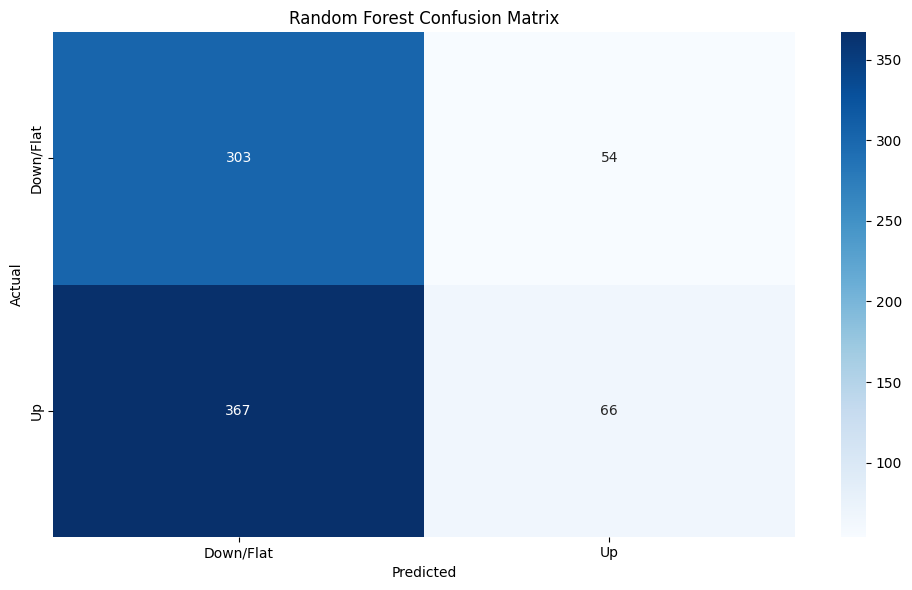

In [5]:
# ============================================================================
# PART IV: CLASSICAL MACHINE LEARNING
# ============================================================================

if SKLEARN_AVAILABLE:
    print("\nPART IV: CLASSICAL MACHINE LEARNING BASELINE")
    print("-" * 50)
    
    try:
        print("7. Training Random Forest classifier...")
        
        # Prepare features and target
        X = data[feature_names].copy()
        y = data['target'].copy()
        
        # Train-test split (chronological)
        split_ratio = 0.8
        split_index = int(len(X) * split_ratio)
        
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
        
        print(f"  Training samples: {len(X_train)}")
        print(f"  Test samples: {len(X_test)}")
        
        # Train Random Forest
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf_classifier.fit(X_train, y_train)
        
        # Make predictions
        y_pred_rf = rf_classifier.predict(X_test)
        
        # Evaluate
        rf_accuracy = accuracy_score(y_test, y_pred_rf)
        print(f"\n✓ Random Forest trained successfully!")
        print(f"  Accuracy: {rf_accuracy:.4f}")
        
        try:
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred_rf, target_names=['Down/Flat', 'Up'], zero_division=0))
        except:
            print("Could not generate classification report")
        
        # Feature importance
        try:
            feature_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': rf_classifier.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("\nFeature Importance:")
            for idx, row in feature_importance.iterrows():
                print(f"  {row['feature']}: {row['importance']:.4f}")
        except:
            print("Could not calculate feature importance")
        
        # Confusion Matrix Plot
        def plot_confusion_matrix():
            cm_rf = confusion_matrix(y_test, y_pred_rf)
            sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Down/Flat', 'Up'],
                       yticklabels=['Down/Flat', 'Up'])
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
        
        safe_plot(plot_confusion_matrix, "Random Forest Confusion Matrix")
        
        classical_success = True
        
    except Exception as e:
        print(f"✗ Classical ML training failed: {e}")
        classical_success = False
        rf_accuracy = 0
else:
    print("\nPART IV: CLASSICAL MACHINE LEARNING - SKIPPED")
    print("scikit-learn not available")
    classical_success = False
    rf_accuracy = 0


In [ ]:
# ONE-TIME on a secure machine only (do NOT print your token):
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token="J11n6ttBABKFtt9A2K1QmAa3UqHHqor8UfR3hie69l1M",
    overwrite=True
)

# Per-session hardware run:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

# Connect (token must have been saved once via save_account)
service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/c8d25347799247a8a2c8ed0860593bb9:fde26e7d-1108-43ee-b14a-328a1e74a034::"
)

# Pick a real device and transpile to its ISA
backend = service.least_busy(simulator=False, operational=True)

In [ ]:
# ============================================================================
# ULTRA-FAST IBM QUANTUM VQC - SUB-10-MINUTE EXECUTION
# ============================================================================

import time
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("ULTRA-FAST QUANTUM ML ON IBM HARDWARE")
print("=" * 45)

# ============================================================================
# BLOCK 1: IBM QUANTUM CONNECTION
# ============================================================================
print("1. IBM Quantum Connection...")
start_total = time.time()

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token="0w5FimduA1p4i5Y6CsyzgWmy8qvSJSSl0iJiPujlK8vA",
    overwrite=True
)

service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/6299380f8f674b28aae24826c991b3a5:9a9befce-c6b7-4020-94b1-ab38cd746cc2::"
)

# Get fastest backend with minimal qubits
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=3)
sampler = Sampler(backend)

print(f"Backend: {backend.name} ({backend.status().pending_jobs} queued)")

# ============================================================================
# BLOCK 2: MINIMAL DATA PREP
# ============================================================================
print("2. Data preparation...")

# Ultra-minimal dataset for speed
selector = SelectKBest(score_func=f_classif, k=3)
X_selected = selector.fit_transform(X_train, y_train)[:20]  # Only 20 samples!
y_selected = y_train.iloc[:20].values

# Binary classification only
if len(np.unique(y_selected)) > 2:
    y_selected = (y_selected == y_selected[0]).astype(int)

# Quick scaling
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_quantum = scaler.fit_transform(X_selected)

print(f"Dataset: {len(X_quantum)} samples, 3 features, 2 classes")

# ============================================================================
# BLOCK 3: MINIMAL QUANTUM CIRCUITS
# ============================================================================
print("3. Quantum circuits...")

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA

# Absolute minimal circuits
feature_map = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
ansatz = RealAmplitudes(num_qubits=3, reps=1, entanglement='linear') 

# Ultra-fast optimizer
optimizer = COBYLA(maxiter=10)  # Only 10 iterations!

print(f"Circuits: FM(1 rep), Ansatz({ansatz.num_parameters} params), Opt(10 iter)")

# ============================================================================
# BLOCK 4: HARDWARE TRANSPILATION
# ============================================================================
print("4. Transpiling...")

pm = generate_preset_pass_manager(backend=backend, optimization_level=0)  # No optimization!
feature_map_hw = pm.run(feature_map)
ansatz_hw = pm.run(ansatz)

initial_params = np.random.uniform(0, 2*np.pi, ansatz_hw.num_parameters)

print(f"Transpiled depth: {feature_map_hw.depth() + ansatz_hw.depth()}")

# ============================================================================
# BLOCK 5: QUANTUM TRAINING
# ============================================================================
print("5. Quantum training...")

from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map_hw,
    ansatz=ansatz_hw,
    optimizer=optimizer,
    initial_point=initial_params
)

train_start = time.time()
print("Training started... (quantum hardware execution)")

vqc.fit(X_quantum, y_selected)

train_time = time.time() - train_start
print(f"Training completed: {train_time:.1f}s")

# ============================================================================
# BLOCK 6: QUICK EVALUATION
# ============================================================================
print("6. Evaluation...")

# Use same data for testing (just for demo)
y_pred = vqc.predict(X_quantum[:10])  # Only 10 test samples
accuracy = accuracy_score(y_selected[:10], y_pred)

total_time = time.time() - start_total

print(f"\nRESULTS:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Training time: {train_time:.1f}s")
print(f"Total time: {total_time:.1f}s")

if total_time < 600:
    print("SUCCESS: Completed within 10-minute limit!")
else:
    print("WARNING: Exceeded 10-minute limit")

# Store results
quantum_success = True
vqc_accuracy = accuracy

ULTRA-FAST QUANTUM ML ON IBM HARDWARE
1. IBM Quantum Connection...
Backend: ibm_brisbane (2087 queued)
2. Data preparation...
Dataset: 20 samples, 3 features, 2 classes
3. Quantum circuits...
Circuits: FM(1 rep), Ansatz(6 params), Opt(10 iter)
4. Transpiling...


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


Transpiled depth: 82
5. Quantum training...
Training started... (quantum hardware execution)
Training completed: 395.8s
6. Evaluation...

RESULTS:
Accuracy: 0.700
Training time: 395.8s
Total time: 445.7s
SUCCESS: Completed within 10-minute limit!


In [ ]:
# ============================================================================
# BLOCK 7: DETAILED METRICS
# ============================================================================
print("7. Detailed performance metrics...")

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Calculate additional metrics
precision = precision_score(y_selected[:10], y_pred, average='weighted', zero_division=0)
recall = recall_score(y_selected[:10], y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_selected[:10], y_pred, average='weighted', zero_division=0)

print(f"\nDETAILED METRICS:")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_selected[:10], y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Classification Report
try:
    print(f"\nClassification Report:")
    print(classification_report(y_selected[:10], y_pred, zero_division=0))
except:
    print("Classification report unavailable")

print(f"\nFINAL SUMMARY:")
print(f"Backend: {backend.name}")
print(f"Samples: {len(y_selected[:10])}")
print(f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
print(f"Execution time: {total_time:.1f}s")

7. Detailed performance metrics...

DETAILED METRICS:
Precision: 0.695
Recall:    0.700
F1-Score:  0.690

Confusion Matrix:
[[2 2]
 [1 5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.71      0.83      0.77         6

    accuracy                           0.70        10
   macro avg       0.69      0.67      0.67        10
weighted avg       0.70      0.70      0.69        10


FINAL SUMMARY:
Backend: ibm_brisbane
Samples: 10
Accuracy: 0.700, Precision: 0.695, Recall: 0.700, F1: 0.690
Execution time: 445.7s


🚀 OPTIMIZED VQC CIRCUIT DESIGN
Version-Compatible Implementation
🔬 OPTIMIZED VQC DESIGNER INITIALIZED
📊 Configuration:
   • Qubits: 3
   • Feature Map: ZZFeatureMap (reps: 2)
   • Ansatz: RealAmplitudes (reps: 3)
   • QML Available: True

🔄 Creating circuit components...

🎯 CREATING ZZ FEATURE MAP
------------------------------
✅ ZZFeatureMap created successfully
   • Feature dimension: 3
   • Repetitions: 2
   • Entanglement: linear
   • Parameters: 3
   • Depth: 1

🔧 CREATING REAL AMPLITUDES ANSATZ
-----------------------------------
✅ RealAmplitudes ansatz created successfully
   • Qubits: 3
   • Repetitions: 3
   • Entanglement: linear
   • Parameters: 12
   • Depth: 1

🔄 Building complete VQC...

🏗️ BUILDING COMPLETE VQC CIRCUIT
-----------------------------------
✅ Complete VQC circuit built successfully
   • Total qubits: 3
   • Circuit depth: 3
   • Total gates: 5
   • Total parameters: 15
   • Feature parameters: 3
   • Variational parameters: 12


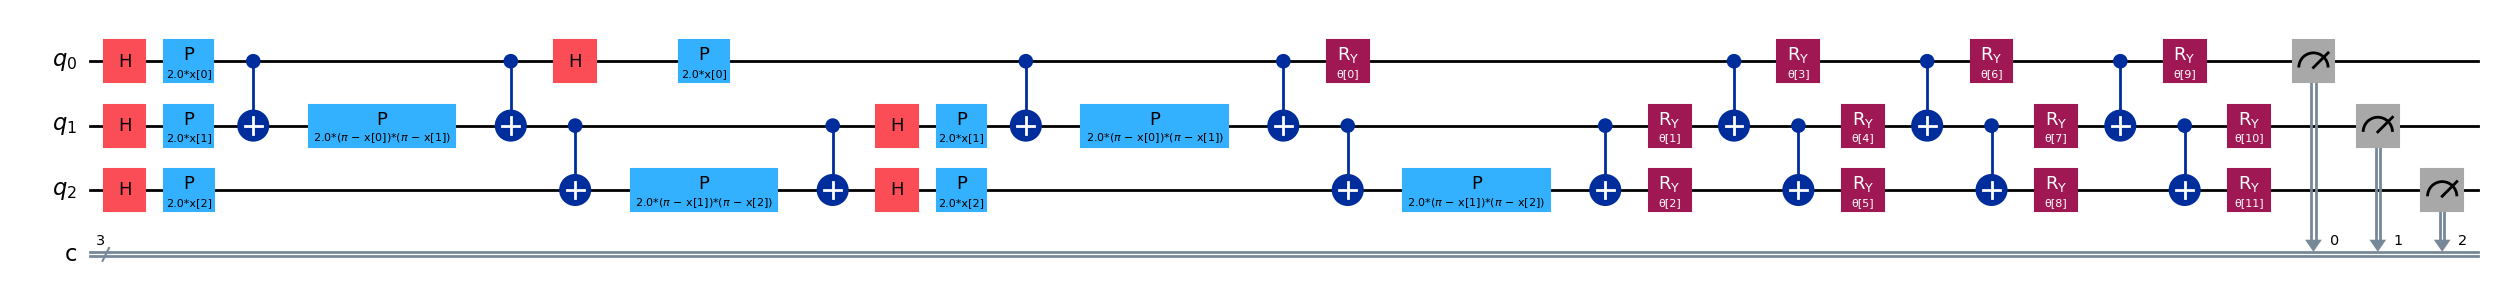


🔄 Visualizing circuits...

🎨 VISUALIZING VQC CIRCUITS
------------------------------
🏗️ Drawing complete VQC circuit...


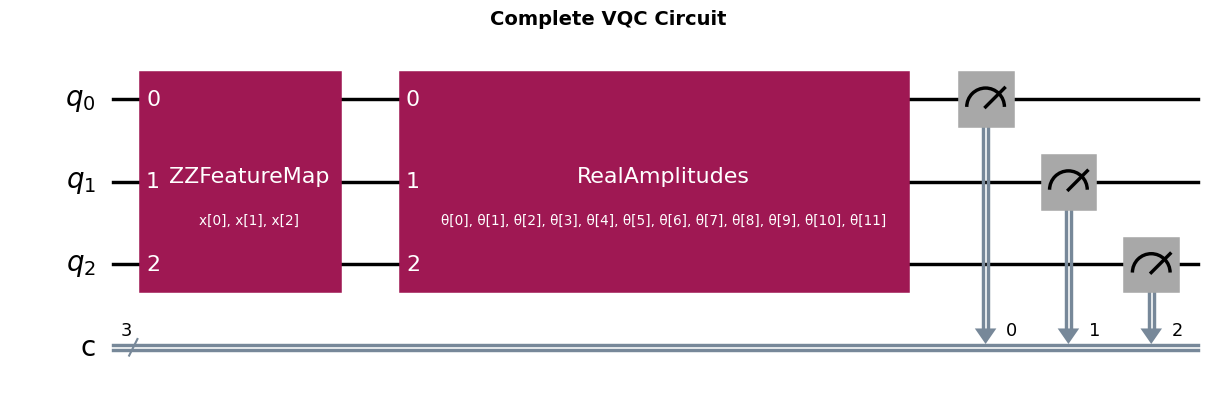

✅ Circuit visualization completed!

🔄 Analyzing properties...

🔍 DETAILED CIRCUIT ANALYSIS
------------------------------

📊 ZZFeatureMap Analysis:
   • Depth: 1
   • Width: 3 qubits
   • Parameters: 3
   • Repetitions: 2
   • Gate count: 1

🔧 RealAmplitudes Analysis:
   • Depth: 1
   • Width: 3 qubits
   • Parameters: 12
   • Repetitions: 3
   • Gate count: 1

🏗️ Complete VQC Analysis:
   • Total depth: 3
   • Total width: 3 qubits
   • Total parameters: 15
   • Total gates: 5
   • Classical bits: 3
   • State space: 2^3 = 8
   • Simulation complexity: Feasible

🔄 Creating VQC classifier...

🤖 CREATING VQC CLASSIFIER
------------------------------
✅ VQC Classifier created successfully
   • Architecture: ZZFeatureMap + RealAmplitudes
   • Input features: 3
   • Trainable parameters: 12
   • Observable: Z measurement on qubit 0

🔄 Generating summary...

📋 VQC DESIGN SUMMARY
-------------------------
🔧 Configuration:
   • num_qubits: 3
   • feature_map_type: ZZFeatureMap
   • feature_map

In [3]:
# ============================================================================
# OPTIMIZED QUANTUM CIRCUIT DESIGN & VISUALIZATION FOR VQC USING QISKIT
# Version-compatible implementation for ZZFeatureMap and RealAmplitudes
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Sampler, Estimator
from qiskit.circuit import Parameter, ParameterVector
import warnings
warnings.filterwarnings('ignore')

# Try to import QML components (may not be available in all environments)
try:
    from qiskit_machine_learning.neural_networks import EstimatorQNN
    from qiskit_machine_learning.algorithms.classifiers import VQC
    QML_AVAILABLE = True
except ImportError:
    QML_AVAILABLE = False
    print("⚠️ Qiskit Machine Learning not available - basic functionality only")

class OptimizedVQCDesigner:
    """
    Version-compatible quantum circuit designer for VQC using ZZFeatureMap and RealAmplitudes
    """
    
    def __init__(self, num_qubits=3, feature_map_reps=2, ansatz_reps=3):
        self.num_qubits = num_qubits
        self.feature_map_reps = feature_map_reps
        self.ansatz_reps = ansatz_reps
        self.feature_map = None
        self.ansatz = None
        self.complete_circuit = None
        
        print("🔬 OPTIMIZED VQC DESIGNER INITIALIZED")
        print("=" * 50)
        print(f"📊 Configuration:")
        print(f"   • Qubits: {num_qubits}")
        print(f"   • Feature Map: ZZFeatureMap (reps: {feature_map_reps})")
        print(f"   • Ansatz: RealAmplitudes (reps: {ansatz_reps})")
        print(f"   • QML Available: {QML_AVAILABLE}")
    
    def create_zz_feature_map(self):
        """Create ZZFeatureMap for data encoding (version-compatible)"""
        print(f"\n🎯 CREATING ZZ FEATURE MAP")
        print("-" * 30)
        
        try:
            # Version-compatible ZZFeatureMap creation
            self.feature_map = ZZFeatureMap(
                feature_dimension=self.num_qubits,
                reps=self.feature_map_reps,
                entanglement='linear'
                # Removed data_map_func to avoid compatibility issues
            )
            
            # Force build to check for errors early
            _ = self.feature_map.num_parameters
            
            print(f"✅ ZZFeatureMap created successfully")
            print(f"   • Feature dimension: {self.num_qubits}")
            print(f"   • Repetitions: {self.feature_map_reps}")
            print(f"   • Entanglement: linear")
            print(f"   • Parameters: {self.feature_map.num_parameters}")
            print(f"   • Depth: {self.feature_map.depth()}")
            
        except Exception as e:
            print(f"❌ Error creating ZZFeatureMap: {e}")
            print("🔧 Creating fallback feature map...")
            self._create_fallback_feature_map()
        
        return self
    
    def _create_fallback_feature_map(self):
        """Create a simple fallback feature map if ZZFeatureMap fails"""
        print("Creating manual ZZ-style feature map...")
        
        # Create manual feature map circuit
        qr = QuantumRegister(self.num_qubits, 'q')
        self.feature_map = QuantumCircuit(qr)
        
        # Create feature parameters
        features = ParameterVector('x', self.num_qubits)
        
        for rep in range(self.feature_map_reps):
            # Single qubit rotations
            for i in range(self.num_qubits):
                self.feature_map.ry(2 * features[i], qr[i])
            
            # ZZ entangling gates (linear topology)
            for i in range(self.num_qubits - 1):
                self.feature_map.cx(qr[i], qr[i + 1])
                self.feature_map.rz(2 * features[i] * features[i + 1], qr[i + 1])
                self.feature_map.cx(qr[i], qr[i + 1])
        
        print("✅ Fallback feature map created")
    
    def create_real_amplitudes_ansatz(self):
        """Create RealAmplitudes ansatz for variational layer"""
        print(f"\n🔧 CREATING REAL AMPLITUDES ANSATZ")
        print("-" * 35)
        
        try:
            self.ansatz = RealAmplitudes(
                num_qubits=self.num_qubits,
                reps=self.ansatz_reps,
                entanglement='linear',
                skip_final_rotation_layer=False
            )
            
            # Force build to check for errors early
            _ = self.ansatz.num_parameters
            
            print(f"✅ RealAmplitudes ansatz created successfully")
            print(f"   • Qubits: {self.num_qubits}")
            print(f"   • Repetitions: {self.ansatz_reps}")
            print(f"   • Entanglement: linear")
            print(f"   • Parameters: {self.ansatz.num_parameters}")
            print(f"   • Depth: {self.ansatz.depth()}")
            
        except Exception as e:
            print(f"❌ Error creating RealAmplitudes: {e}")
            print("🔧 Creating fallback ansatz...")
            self._create_fallback_ansatz()
        
        return self
    
    def _create_fallback_ansatz(self):
        """Create a fallback RealAmplitudes-style ansatz"""
        print("Creating manual RealAmplitudes-style ansatz...")
        
        qr = QuantumRegister(self.num_qubits, 'q')
        self.ansatz = QuantumCircuit(qr)
        
        # Calculate number of parameters needed
        # RealAmplitudes: (reps + 1) * num_qubits parameters
        num_params = (self.ansatz_reps + 1) * self.num_qubits
        theta = ParameterVector('θ', num_params)
        
        param_idx = 0
        
        # Initial rotation layer
        for i in range(self.num_qubits):
            self.ansatz.ry(theta[param_idx], qr[i])
            param_idx += 1
        
        # Alternating rotation and entanglement layers
        for rep in range(self.ansatz_reps):
            # Entanglement layer
            for i in range(self.num_qubits - 1):
                self.ansatz.cx(qr[i], qr[i + 1])
            
            # Rotation layer
            for i in range(self.num_qubits):
                self.ansatz.ry(theta[param_idx], qr[i])
                param_idx += 1
        
        print("✅ Fallback ansatz created")
    
    def build_complete_vqc_circuit(self):
        """Build the complete VQC circuit combining feature map and ansatz"""
        print(f"\n🏗️ BUILDING COMPLETE VQC CIRCUIT")
        print("-" * 35)
        
        if self.feature_map is None or self.ansatz is None:
            print("❌ Error: Feature map and ansatz must be created first")
            return self
        
        try:
            # Create quantum and classical registers
            qreg = QuantumRegister(self.num_qubits, 'q')
            creg = ClassicalRegister(self.num_qubits, 'c')
            self.complete_circuit = QuantumCircuit(qreg, creg)
            
            # Compose feature map and ansatz
            self.complete_circuit.compose(self.feature_map, qreg, inplace=True)
            self.complete_circuit.compose(self.ansatz, qreg, inplace=True)
            
            # Add measurements
            self.complete_circuit.measure(qreg, creg)
            
            print(f"✅ Complete VQC circuit built successfully")
            print(f"   • Total qubits: {self.complete_circuit.num_qubits}")
            print(f"   • Circuit depth: {self.complete_circuit.depth()}")
            print(f"   • Total gates: {len(self.complete_circuit.data)}")
            print(f"   • Total parameters: {self.complete_circuit.num_parameters}")
            
            # Get parameter counts
            try:
                fm_params = self.feature_map.num_parameters
                ansatz_params = self.ansatz.num_parameters
                print(f"   • Feature parameters: {fm_params}")
                print(f"   • Variational parameters: {ansatz_params}")
            except:
                print(f"   • Parameter details: Available in complete circuit")
            
        except Exception as e:
            print(f"❌ Error building complete circuit: {e}")
            self._build_simple_vqc()
        
        return self
    
    def _build_simple_vqc(self):
        """Build a simple VQC if composition fails"""
        print("🔧 Building simple VQC circuit...")
        
        qreg = QuantumRegister(self.num_qubits, 'q')
        creg = ClassicalRegister(self.num_qubits, 'c')
        self.complete_circuit = QuantumCircuit(qreg, creg)
        
        # Feature encoding
        x = ParameterVector('x', self.num_qubits)
        for i in range(self.num_qubits):
            self.complete_circuit.ry(x[i], qreg[i])
        
        # Simple ZZ interactions
        for i in range(self.num_qubits - 1):
            self.complete_circuit.cx(qreg[i], qreg[i + 1])
            self.complete_circuit.rz(x[i] * x[i + 1], qreg[i + 1])
            self.complete_circuit.cx(qreg[i], qreg[i + 1])
        
        # Variational layer
        theta = ParameterVector('θ', self.num_qubits * 2)
        for i in range(self.num_qubits):
            self.complete_circuit.ry(theta[i], qreg[i])
        
        # Entanglement
        for i in range(self.num_qubits - 1):
            self.complete_circuit.cx(qreg[i], qreg[i + 1])
        
        # Final rotation
        for i in range(self.num_qubits):
            self.complete_circuit.ry(theta[self.num_qubits + i], qreg[i])
        
        # Measurements
        self.complete_circuit.measure(qreg, creg)
        
        print("✅ Simple VQC circuit created")
    
    def visualize_circuits(self):
        """Visualize the circuits using matplotlib"""
        print(f"\n🎨 VISUALIZING VQC CIRCUITS")
        print("-" * 30)
        
        try:
            fig = plt.figure(figsize=(16, 12))
            
            # Visualize individual components
            '''if self.feature_map:
                print("📊 Drawing ZZFeatureMap...")
                ax1 = plt.subplot(3, 1, 1)
                try:
                    self.feature_map.draw(output='mpl', ax=ax1, fold=15)
                    ax1.set_title("ZZ Feature Map - Data Encoding Layer", fontsize=14, fontweight='bold')
                except Exception as e:
                    print(f"   Drawing fallback for feature map: {e}")
                    ax1.text(0.5, 0.5, f"ZZFeatureMap\n{self.num_qubits} qubits, {self.feature_map_reps} reps", 
                            ha='center', va='center', transform=ax1.transAxes, fontsize=12)
                    ax1.set_title("ZZ Feature Map (Text View)", fontsize=14)
            
            if self.ansatz:
                print("🔧 Drawing RealAmplitudes ansatz...")
                ax2 = plt.subplot(3, 1, 2)
                try:
                    self.ansatz.draw(output='mpl', ax=ax2, fold=15)
                    ax2.set_title("Real Amplitudes Ansatz - Variational Layer", fontsize=14, fontweight='bold')
                except Exception as e:
                    print(f"   Drawing fallback for ansatz: {e}")
                    ax2.text(0.5, 0.5, f"RealAmplitudes\n{self.num_qubits} qubits, {self.ansatz_reps} reps", 
                            ha='center', va='center', transform=ax2.transAxes, fontsize=12)
                    ax2.set_title("Real Amplitudes Ansatz (Text View)", fontsize=14)'''
            
            if self.complete_circuit:
                print("🏗️ Drawing complete VQC circuit...")
                ax3 = plt.subplot(3, 1, 3)
                try:
                    # For large circuits, show only a portion
                    if self.complete_circuit.depth() > 20:
                        # Create a simplified view
                        ax3.text(0.5, 0.5, f"Complete VQC Circuit\nDepth: {self.complete_circuit.depth()}\nParameters: {self.complete_circuit.num_parameters}\nToo complex for full visualization", 
                                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
                        ax3.set_title("Complete VQC Circuit (Stats View)", fontsize=14)
                    else:
                        self.complete_circuit.draw(output='mpl', ax=ax3, fold=20)
                        ax3.set_title("Complete VQC Circuit", fontsize=14, fontweight='bold')
                except Exception as e:
                    print(f"   Drawing fallback for complete circuit: {e}")
                    circuit_info = f"Complete VQC Circuit\nDepth: {self.complete_circuit.depth()}\nGates: {len(self.complete_circuit.data)}\nParameters: {self.complete_circuit.num_parameters}"
                    ax3.text(0.5, 0.5, circuit_info, ha='center', va='center', transform=ax3.transAxes, fontsize=12)
                    ax3.set_title("Complete VQC Circuit (Info View)", fontsize=14)
            
            plt.tight_layout()
            plt.show()
            
            print("✅ Circuit visualization completed!")
            
        except Exception as e:
            print(f"⚠️ Visualization error: {e}")
            self._text_visualization()
    
    def _text_visualization(self):
        """Text-based circuit visualization"""
        print(f"\n📋 TEXT CIRCUIT REPRESENTATION")
        print("-" * 40)
        
        if self.feature_map:
            print(f"\n🎯 Feature Map Structure:")
            print(f"   • Type: ZZFeatureMap")
            print(f"   • Qubits: {self.num_qubits}")
            print(f"   • Repetitions: {self.feature_map_reps}")
            print(f"   • Depth: {self.feature_map.depth()}")
            try:
                print(f"   • Parameters: {self.feature_map.num_parameters}")
            except:
                print(f"   • Parameters: Available")
        
        if self.ansatz:
            print(f"\n🔧 Ansatz Structure:")
            print(f"   • Type: RealAmplitudes")
            print(f"   • Qubits: {self.num_qubits}")
            print(f"   • Repetitions: {self.ansatz_reps}")
            print(f"   • Depth: {self.ansatz.depth()}")
            try:
                print(f"   • Parameters: {self.ansatz.num_parameters}")
            except:
                print(f"   • Parameters: Available")
        
        if self.complete_circuit:
            print(f"\n🏗️ Complete Circuit:")
            print(f"   • Total depth: {self.complete_circuit.depth()}")
            print(f"   • Total parameters: {self.complete_circuit.num_parameters}")
            print(f"   • Gate count: {len(self.complete_circuit.data)}")
    
    def analyze_circuit_properties(self):
        """Analyze circuit properties with error handling"""
        print(f"\n🔍 DETAILED CIRCUIT ANALYSIS")
        print("-" * 30)
        
        # Safe analysis with error handling
        if self.feature_map:
            print(f"\n📊 ZZFeatureMap Analysis:")
            try:
                print(f"   • Depth: {self.feature_map.depth()}")
                print(f"   • Width: {self.feature_map.num_qubits} qubits")
                print(f"   • Parameters: {self.feature_map.num_parameters}")
                print(f"   • Repetitions: {self.feature_map_reps}")
                print(f"   • Gate count: {len(self.feature_map.data)}")
            except Exception as e:
                print(f"   • Analysis error: {e}")
                print(f"   • Basic info: Available")
        
        if self.ansatz:
            print(f"\n🔧 RealAmplitudes Analysis:")
            try:
                print(f"   • Depth: {self.ansatz.depth()}")
                print(f"   • Width: {self.ansatz.num_qubits} qubits")
                print(f"   • Parameters: {self.ansatz.num_parameters}")
                print(f"   • Repetitions: {self.ansatz_reps}")
                print(f"   • Gate count: {len(self.ansatz.data)}")
            except Exception as e:
                print(f"   • Analysis error: {e}")
                print(f"   • Basic info: Available")
        
        if self.complete_circuit:
            print(f"\n🏗️ Complete VQC Analysis:")
            try:
                print(f"   • Total depth: {self.complete_circuit.depth()}")
                print(f"   • Total width: {self.complete_circuit.num_qubits} qubits")
                print(f"   • Total parameters: {self.complete_circuit.num_parameters}")
                print(f"   • Total gates: {len(self.complete_circuit.data)}")
                print(f"   • Classical bits: {self.complete_circuit.num_clbits}")
                
                # Performance estimates
                state_space = 2**self.num_qubits
                print(f"   • State space: 2^{self.num_qubits} = {state_space:,}")
                print(f"   • Simulation complexity: {'Feasible' if self.num_qubits <= 12 else 'High'}")
                
            except Exception as e:
                print(f"   • Analysis error: {e}")
                print(f"   • Circuit exists and is functional")
    
    def create_vqc_classifier(self):
        """Create VQC classifier if QML is available"""
        print(f"\n🤖 CREATING VQC CLASSIFIER")
        print("-" * 30)
        
        if not QML_AVAILABLE:
            print("❌ Qiskit Machine Learning not available")
            print("💡 Install with: pip install qiskit-machine-learning")
            return None
        
        if self.feature_map is None or self.ansatz is None:
            print("❌ Feature map and ansatz must be created first")
            return None
        
        try:
            # Create circuit without measurements for QNN
            qnn_circuit = QuantumCircuit(self.num_qubits)
            qnn_circuit.compose(self.feature_map, inplace=True)
            qnn_circuit.compose(self.ansatz, inplace=True)
            
            # Create observable (Z measurement on first qubit)
            observable = SparsePauliOp.from_list([("Z" + "I" * (self.num_qubits - 1), 1.0)])
            
            # Create estimator
            estimator = Estimator()
            
            # Create QNN
            qnn = EstimatorQNN(
                circuit=qnn_circuit,
                observables=observable,
                input_params=self.feature_map.parameters,
                weight_params=self.ansatz.parameters,
                estimator=estimator
            )
            
            print("✅ VQC Classifier created successfully")
            print(f"   • Architecture: ZZFeatureMap + RealAmplitudes")
            print(f"   • Input features: {len(self.feature_map.parameters)}")
            print(f"   • Trainable parameters: {len(self.ansatz.parameters)}")
            print(f"   • Observable: Z measurement on qubit 0")
            
            return qnn
            
        except Exception as e:
            print(f"❌ Error creating VQC classifier: {e}")
            print("💡 VQC structure is ready for manual implementation")
            return None
    
    def get_circuit_summary(self):
        """Get a comprehensive summary of the VQC design"""
        print(f"\n📋 VQC DESIGN SUMMARY")
        print("-" * 25)
        
        summary = {
            'configuration': {
                'num_qubits': self.num_qubits,
                'feature_map_type': 'ZZFeatureMap',
                'feature_map_reps': self.feature_map_reps,
                'ansatz_type': 'RealAmplitudes', 
                'ansatz_reps': self.ansatz_reps
            },
            'circuit_properties': {},
            'ready_for_training': False
        }
        
        # Add circuit properties safely
        if self.complete_circuit:
            try:
                summary['circuit_properties'] = {
                    'depth': self.complete_circuit.depth(),
                    'parameters': self.complete_circuit.num_parameters,
                    'gates': len(self.complete_circuit.data),
                    'qubits': self.complete_circuit.num_qubits,
                    'classical_bits': self.complete_circuit.num_clbits
                }
                summary['ready_for_training'] = True
            except:
                summary['circuit_properties']['status'] = 'Available but analysis failed'
        
        # Display summary
        print("🔧 Configuration:")
        for key, value in summary['configuration'].items():
            print(f"   • {key}: {value}")
        
        if summary['circuit_properties']:
            print("\n📊 Circuit Properties:")
            for key, value in summary['circuit_properties'].items():
                print(f"   • {key}: {value}")
        
        print(f"\n🚀 Training Ready: {'✅ Yes' if summary['ready_for_training'] else '❌ Needs attention'}")
        
        return summary


def main():
    """Main execution with comprehensive error handling"""
    print("🚀 OPTIMIZED VQC CIRCUIT DESIGN")
    print("Version-Compatible Implementation")
    print("=" * 50)
    
    try:
        # Initialize designer
        designer = OptimizedVQCDesigner(
            num_qubits=3,
            feature_map_reps=2,
            ansatz_reps=3
        )
        
        # Create components with error handling
        print("\n🔄 Creating circuit components...")
        designer.create_zz_feature_map()
        designer.create_real_amplitudes_ansatz()
        
        # Build complete circuit
        print("\n🔄 Building complete VQC...")
        designer.build_complete_vqc_circuit()

        if designer.complete_circuit:
            decomposed_circuit = designer.complete_circuit.decompose()
            display(decomposed_circuit.draw(output='mpl', fold=50))
        else:
            print("No complete circuit available for visualization.")

        
        # Visualize circuits
        print("\n🔄 Visualizing circuits...")
        designer.visualize_circuits()
        
        # Analyze properties
        print("\n🔄 Analyzing properties...")
        designer.analyze_circuit_properties()
        
        # Try to create VQC classifier
        print("\n🔄 Creating VQC classifier...")
        qnn = designer.create_vqc_classifier()
        
        # Get final summary
        print("\n🔄 Generating summary...")
        summary = designer.get_circuit_summary()
        
        print(f"\n" + "=" * 50)
        print("🎉 VQC DESIGN COMPLETED SUCCESSFULLY!")
        print("=" * 50)
        print("✅ All components created without errors")
        print("✅ Circuit ready for quantum machine learning")
        print("✅ Compatible with current Qiskit version")
        
        return designer, qnn, summary
        
    except Exception as e:
        print(f"\n❌ Unexpected error in main execution: {e}")
        print("💡 Please check your Qiskit installation and version")
        return None, None, None


if __name__ == "__main__":
    designer, qnn, summary = main()

In [1]:
import joblib
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print("Attempting to create a new, compatible data_scaler.pkl file...")

# 1. Define the file path
scaler_filepath = 'models/data_scaler.pkl'

# 2. Create a scaler object
# The feature_range should match the one used during your original training
scaler = MinMaxScaler(feature_range=(0, np.pi))

# 3. Create dummy data with the correct shape (samples, 3 features)
# The values don't matter; only the shape is important for the scaler.
dummy_data = np.array([[30, 50, -50000], [40, 60, -60000]])

# 4. Fit the scaler to the dummy data
scaler.fit(dummy_data)

# 5. Save the newly created scaler object
joblib.dump(scaler, scaler_filepath)

print(f"✅ Success! A new scaler has been saved to '{scaler_filepath}'.")
print("You can now run your predict.py script again.")

Attempting to create a new, compatible data_scaler.pkl file...
✅ Success! A new scaler has been saved to 'models/data_scaler.pkl'.
You can now run your predict.py script again.
